<a href="https://colab.research.google.com/github/Fernsrea/flow_matching/blob/main/DeterministicMask.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import torch
from torchvision import datasets, transforms

# Parameters
mask_size = 8  # Size of the square mask
image_size = 28

# Create a deterministic center square mask
def create_center_mask():
    mask = torch.ones((image_size, image_size), dtype=torch.float32)
    start = (image_size - mask_size) // 2
    end = start + mask_size
    mask[start:end, start:end] = 0.0
    return mask

# Load MNIST
transform = transforms.ToTensor()
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Apply mask to an image
mask = create_center_mask()
sample_image, _ = mnist[0]
masked_image = sample_image.squeeze() * mask

# masked_image now contains the image with a fixed square mask


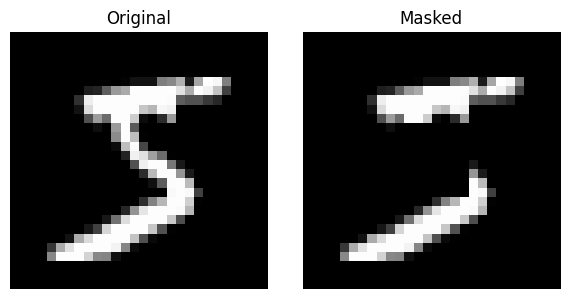

In [4]:
import matplotlib.pyplot as plt

# Sample image and mask application
sample_image, _ = mnist[0]
original = sample_image.squeeze()
masked = original * mask

# Plotting
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(original, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Masked")
plt.imshow(masked, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()
